In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.chdir('..')

import sys
sys.path.append(os.getcwd())

import evaluation
import models

In [6]:
train, test = evaluation.load_data_real('235k')
train.shape, test.shape

((212015, 24), (23000, 24))

In [7]:
def plot_series_sample(data, seed=1):
    np.random.seed(seed)
    ind = np.random.permutation(len(data))[:16]

    plt.figure(figsize=(16, 10))

    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        series = data[ind[i]]
        ax.plot(series)
        ax.set_title('Series index={}'.format(ind[i]))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()

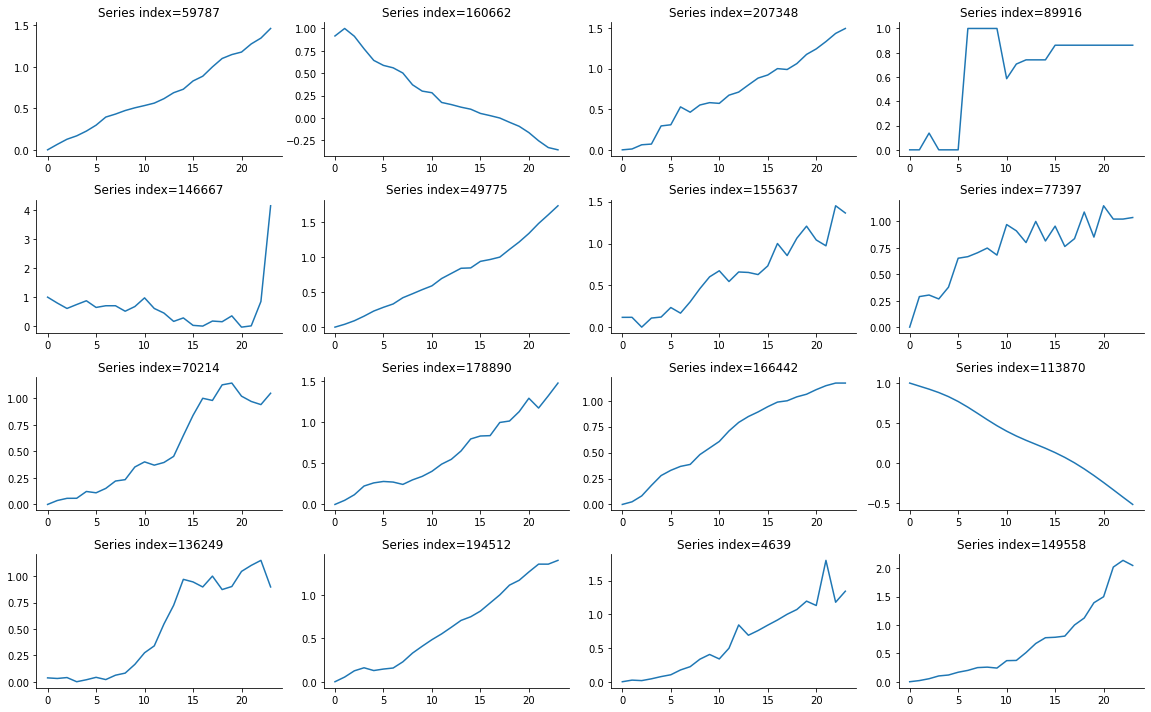

In [8]:
plot_series_sample(train)

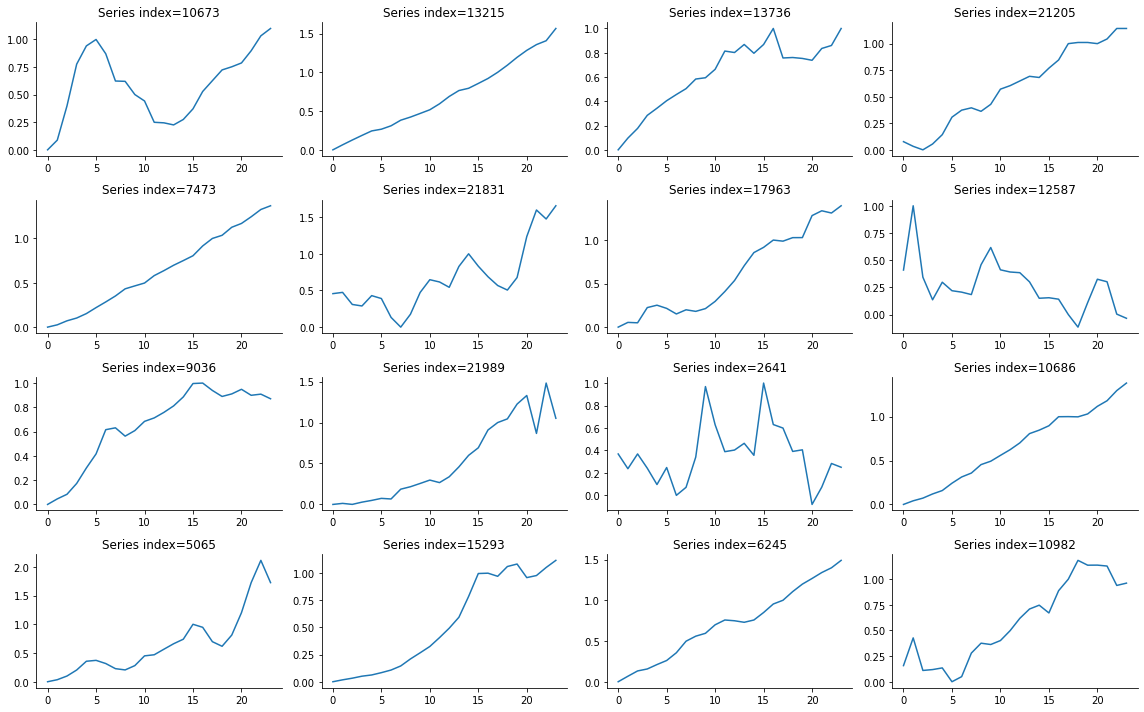

In [9]:
plot_series_sample(test)

In [12]:
encoder, autoencoder = models.get_model('autoencoder_2layer_bn')({'base_layer_size': 64,
                                                                  'input_seq_length': train.shape[1]})

autoencoder.fit(train, train, epochs=10)

test_2d = encoder.predict(test)
train_2d = encoder.predict(train)

In [14]:
autoencoder.fit(train, train, epochs=10)

Epoch 1/10
6626/6626 [==============================] - 287s 43ms/step - loss: 0.1475 - accuracy: 0.0856
Epoch 2/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1411 - accuracy: 0.0863
Epoch 3/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1374 - accuracy: 0.0864
Epoch 4/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1348 - accuracy: 0.0870
Epoch 5/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1330 - accuracy: 0.0870
Epoch 6/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1349 - accuracy: 0.0870
Epoch 7/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1328 - accuracy: 0.0869
Epoch 8/10
6626/6626 [==============================] - 280s 42ms/step - loss: 0.1321 - accuracy: 0.0867
Epoch 9/10
6626/6626 [==============================] - 278s 42ms/step - loss: 0.1316 - accuracy: 0.0870
Epoch 10/10
6626/6626 [==============================] 

In [15]:
test_2d = encoder.predict(test)
train_2d = encoder.predict(train)

In [21]:
def jointplot(train_2d, test_2d, xlabel='x', ylabel='y'):
    
    tr_x, tr_y = train_2d.T
    ts_x, ts_y = test_2d.T
    
    df = pd.DataFrame({xlabel: np.r_[tr_x, ts_x], ylabel: np.r_[tr_y, ts_y],
                       'type': ['train'] * len(tr_x) + ['test'] * len(ts_x)})

    sns.jointplot(data=df, x=xlabel, y=ylabel, hue='type')

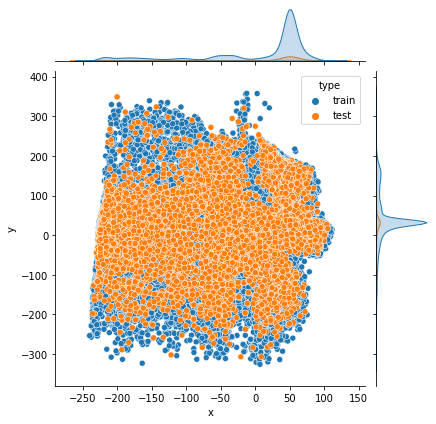

In [22]:
jointplot(train_2d, test_2d)

In [24]:
train_feats = evaluation.visualization.extract_features(train)
test_feats = evaluation.visualization.extract_features(test)

na_cols = pd.concat([train_feats, test_feats]).isna().any()

scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_feats.loc[:, ~na_cols])
x_test = scaler.transform(test_feats.loc[:, ~na_cols])

x_train.shape, x_train.shape

Feature Extraction: 100%|██████████| 120/120 [01:38<00:00,  1.21it/s]


In [30]:
del encoder, autoencoder
tf.keras.backend.clear_session()

encoder, autoencoder = models.get_model('autoencoder_2layer_bn')({'base_layer_size': 64,
                                                                  'input_seq_length': x_train.shape[1]})

autoencoder.fit(x_train, x_train, epochs=10)

test_2d_feats = encoder.predict(x_test)
train_2d_feats = encoder.predict(x_train)

Epoch 1/10
6626/6626 [==============================] - 1267s 191ms/step - loss: 0.0388 - accuracy: 0.2116
Epoch 2/10
6626/6626 [==============================] - 1266s 191ms/step - loss: 0.0327 - accuracy: 0.2122
Epoch 3/10
6626/6626 [==============================] - 1111s 168ms/step - loss: 0.0316 - accuracy: 0.2123
Epoch 4/10
6626/6626 [==============================] - 1172s 177ms/step - loss: 0.0310 - accuracy: 0.2123
Epoch 5/10
6626/6626 [==============================] - 1300s 196ms/step - loss: 0.0306 - accuracy: 0.2123
Epoch 6/10
6626/6626 [==============================] - 1297s 196ms/step - loss: 0.0302 - accuracy: 0.2124
Epoch 7/10
6626/6626 [==============================] - 1299s 196ms/step - loss: 0.0301 - accuracy: 0.2124
Epoch 8/10
6626/6626 [==============================] - 1299s 196ms/step - loss: 0.0305 - accuracy: 0.2123
Epoch 9/10
6626/6626 [==============================] - 1298s 196ms/step - loss: 0.0304 - accuracy: 0.2123
Epoch 10/10
6626/6626 [==============

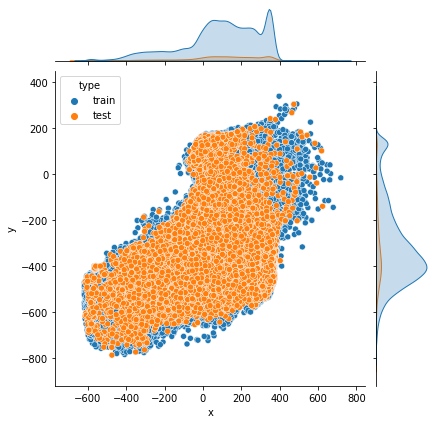

In [31]:
jointplot(train_2d_feats, test_2d_feats)

In [ ]:
samples_dir = Path('../samples/vanilla_lstm_large_235k/'.format(name))

samples_file = sorted([str(f) for f in samples_dir.glob('*.h5')])[-1]

with h5py.File(samples_file, 'r') as hf:
    x = np.array(hf.get('X'))